<a name="top" id="top"></a>

<div align="center">
    <h1>Convolutional Neural Network </h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <a href="https://colab.research.google.com/github/SECQUOIA/PU_CHE597_DSinChemE/blob/main/8-Linear_Regression/Linear_Regression.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

# PyTorch - Convolutional Neural Network
## Table of Contents
- [Convolutions](#convolutions)
- [LeNet on MNIST Dataset](#lenet-on-mnist-dataset)

In [1]:
# If using this on Google colab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False


<b>If you are using google colab you should save this notebook and any associated textfiles to their own folder on your google drive. Then you will need to adapt the following commands so that the notebook runs from the location of that folder.</b>


In [2]:
# If you want to use Google Drive to save/load files, set this to True
USE_GOOGLE_DRIVE = False
if IN_COLAB and USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

    # Colab command to navigate to the folder holding the homework,
    # CHANGE FOR YOUR SPECIFIC FOLDER LOCATION IN GOOGLE DRIVE
    # Note: if there are spaces in the path, you need to preceed them with a backslash '\'
    %cd /content/drive/My\ Drive/CHE597/Notebooks/15-Pytorch_convolutions

In [3]:
# Preliminary Imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import math
import matplotlib.pyplot as plt

## Convolutions
In the following cells we will implement our own convolutional layers using pytorch tensors to show how the operations work. 

In [4]:
# X: input layer
# K: kernel (matrix with weights)
def corr2d(X, K, pad=0):
  h, w = K.shape # height and width of the kernel    
  if pad:
    X_corr = torch.zeros((X.shape[0]+2*pad,X.shape[1]+2*pad)) # padding occurs on each side to *2
    X_corr[pad:-pad,pad:-pad] = X # inside is filled with X
  else:
    X_corr = X
  Y = torch.zeros((X_corr.shape[0] - h + 1, X_corr.shape[1] - w + 1)) # output will have -h+1 and -w+1 of X_corr dim
  for i in range(Y.shape[0]):       
    for j in range(Y.shape[1]):            
      Y[i, j] = (X_corr[i:i + h, j:j + w] * K).sum() # product and sum over kernel
  return Y

The `corr2d()` function carriers kernel-based convolution on a pytorch tensor. Let's see a couple examples:

In [5]:
# Examples
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [6]:
corr2d(X,K,pad=1) # effect of padding

tensor([[ 0.,  3.,  8.,  4.],
        [ 9., 19., 25., 10.],
        [21., 37., 43., 16.],
        [ 6.,  7.,  8.,  0.]])

In [7]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

## LeNet on MNIST Dataset
Load the datasets and create the dataloader objects

In [8]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Loading the dataset and preprocessing (means and stds are precomputed for the normalizations)
batch_size = 64
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)

test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                          download=True)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [9]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__() # required in all pytorch models
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.sig1 = nn.Sigmoid()
        self.fc1 = nn.Linear(120, 84)
        self.sig2 = nn.Sigmoid()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.sig1(out)
        out = self.fc1(out)
        out = self.sig2(out)
        out = self.fc2(out)
        return out

epoch 1/10, step 100/938, loss: 2.280082941055298
epoch 1/10, step 200/938, loss: 1.1874890327453613
epoch 1/10, step 200/938, loss: 1.1874890327453613
epoch 1/10, step 300/938, loss: 0.7326946258544922
epoch 1/10, step 300/938, loss: 0.7326946258544922
epoch 1/10, step 400/938, loss: 0.6529419422149658
epoch 1/10, step 400/938, loss: 0.6529419422149658
epoch 1/10, step 500/938, loss: 0.4106264114379883
epoch 1/10, step 500/938, loss: 0.4106264114379883
epoch 1/10, step 600/938, loss: 0.342691570520401
epoch 1/10, step 600/938, loss: 0.342691570520401
epoch 1/10, step 700/938, loss: 0.3583642542362213
epoch 1/10, step 700/938, loss: 0.3583642542362213
epoch 1/10, step 800/938, loss: 0.17326392233371735
epoch 1/10, step 800/938, loss: 0.17326392233371735
epoch 1/10, step 900/938, loss: 0.20584136247634888
epoch 1/10, step 900/938, loss: 0.20584136247634888
epoch 2/10, step 100/938, loss: 0.09913285821676254
epoch 2/10, step 100/938, loss: 0.09913285821676254
epoch 2/10, step 200/938, lo

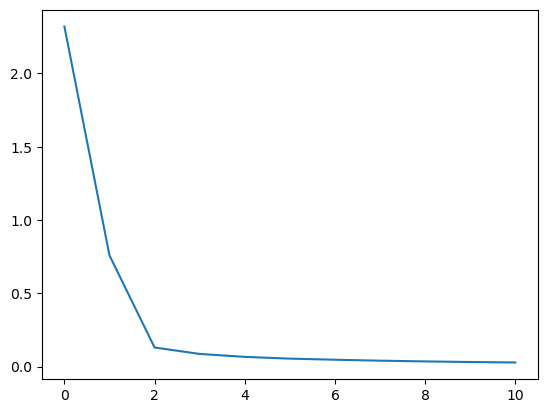

In [11]:
# 1. model definition
num_classes = 10
model = LeNet5(num_classes).to(device)

# 2. loss function
loss=nn.CrossEntropyLoss() # calculates the sum(-log(p)) of the logits as an error function

# Training Loop
N_epoch = 1
lr = 0.001
N_epochs = 10
N_steps = math.ceil(len(train_dataset)/batch_size) # this is how many batches need to be drawn to run over the whole dataset
f_print = 100 # print frequency for diagnostics
optimizer = torch.optim.Adam(model.parameters(),lr=lr) # Adam is one of many optimizers available as pytorch optimizer classes. We need to pass the list of tensors that we want to be trained.
batch_loss = 0.0
with torch.no_grad():
    epoch_losses = [
        np.mean([
            loss(model(x.to(device)), y.to(device)).item()  # Ensure x and y are on the same device as the model
            for x, y in train_loader
        ])
    ] # This is potentially very expensive

# loop over epochs
for epoch in range(N_epochs):

  # loop over batches
  for step, (x,y) in enumerate(train_loader):

    # for GPU we would want to send these
    x = x.to(device)
    y = y.to(device)
        
    # forward pass
    yp = model(x)

    # calculate loss
    l = loss(yp,y)

    # calculate gradient (backward pass from loss function)
    l.backward() # calculates dl/dw since w is involved in the computation of loss and w has requires_grad=True
  
    # update weights
    optimizer.step() # since we passed w at initialization, the optimizer knows what we want to update. 
  
    # zero out gradient for next call
    optimizer.zero_grad() # we need to clear the gradient before the next call or it will accumulate

    # print diagnostics
    if (step+1) % f_print == 0: 
      print(f"epoch {epoch+1}/{N_epochs}, step {step+1}/{N_steps}, loss: {l.item()}") 
    
    # accumulate the batch loss to calculate an epoch average at the end
    batch_loss += l.item()
    
  # grab loss at the end of the epoch
  epoch_losses += [batch_loss/N_steps]
  batch_loss = 0.0 # reset variable for calculating the average on the next epoch

# plot the learning curve
plt.plot(np.arange(N_epochs+1),epoch_losses)

Text(0, 0.5, 'Loss')

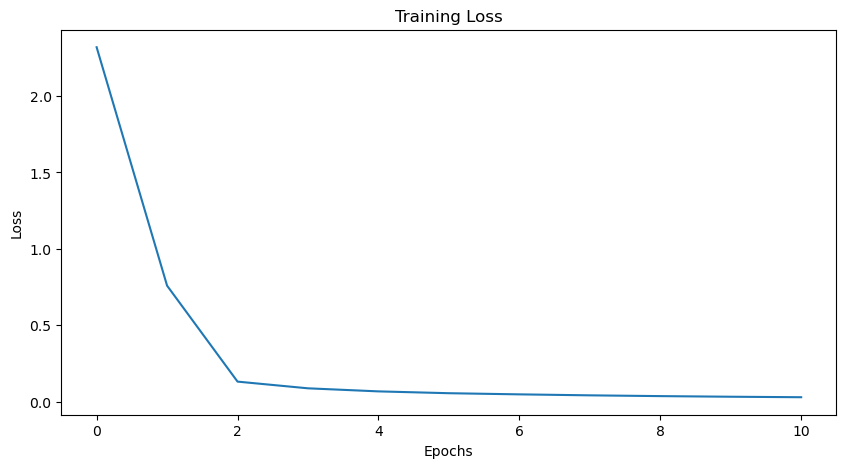

In [12]:
# Plot the learning curve, with training losses
plt.figure(figsize=(10, 5))
plt.plot(np.arange(N_epochs+1),epoch_losses)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


In [13]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images) # make the prediction on the batch
        _, predicted = torch.max(outputs.data, 1) # convert probabilities to majority label (returns values,indices) 
        total += labels.size(0) # increment the number of samples by the batch size
        correct += (predicted == labels).sum().item() # sum the elements where the predictions were correct (sum behavior on bools counts each True as 1)
    print(f'Accuracy on test set ({total} images): {100 * correct / total}%')


Accuracy on test set (10000 images): 98.74%
